# Exploratory Data Analysis (EDA)
The Ask A Manager Salary Survey 2021 dataset is used for this Regression Task.

The goal of this project will be to understand which factors affect annual salary, and create models to predict it.

In [55]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
from numpy.typing import NDArray
from scipy import stats
import textwrap

In [56]:
# Read Raw Data
FILE_NAME: str = "../../data/raw/salary-survey.csv"
DATASET: pl.DataFrame = pl.read_csv(FILE_NAME)

# The Raw Survey Dataset

In [57]:
DATASET.describe()

statistic,Timestamp,How old are you?,What industry do you work in?,Job title,"If your job title needs additional context, please clarify here:","What is your annual salary? (You'll indicate the currency in a later question. If you are part-time or hourly, please enter an annualized equivalent -- what you would earn if you worked the job 40 hours a week, 52 weeks a year.)","How much additional monetary compensation do you get, if any (for example, bonuses or overtime in an average year)? Please only include monetary compensation here, not the value of benefits.",Please indicate the currency,"If """"Other,"""" please indicate the currency here:","If your income needs additional context, please provide it here:",What country do you work in?,"If you're in the U.S., what state do you work in?",What city do you work in?,How many years of professional work experience do you have overall?,How many years of professional work experience do you have in your field?,What is your highest level of education completed?,What is your gender?,What is your race? (Choose all that apply.)
str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str
"""count""","""28153""","""28153""","""28076""","""28153""","""7285""","""28153""",20816.0,"""28153""","""225""","""3060""","""28153""","""23100""","""28153""","""28153""","""28153""","""27924""","""27977""","""27969"""
"""null_count""","""0""","""0""","""77""","""0""","""20868""","""0""",7337.0,"""0""","""27928""","""25093""","""0""","""5053""","""0""","""0""","""0""","""229""","""176""","""184"""
"""mean""",null,null,null,null,null,null,18237.136385,null,null,null,null,null,null,null,null,null,null,null
"""std""",null,null,null,null,null,null,833164.512063,null,null,null,null,null,null,null,null,null,null,null
"""min""","""1/11/2022 13:26:41""","""18-24""",""" Buyer""",""" Analyst""",""" ""","""0""",0.0,"""AUD/NZD""","""$76,302.34""",""" """,""" New Zealand""","""Alabama""",""" ""","""1 year or less""","""1 year or less""","""College degree""","""Man""","""Another option not listed here…"
"""25%""",null,null,null,null,null,null,0.0,null,null,null,null,null,null,null,null,null,null,null
"""50%""",null,null,null,null,null,null,2000.0,null,null,null,null,null,null,null,null,null,null,null
"""75%""",null,null,null,null,null,null,10000.0,null,null,null,null,null,null,null,null,null,null,null
"""max""","""9/9/2024 18:43:02""","""under 18""","""wholesale distribution""","""yard control""","""“Staff” is the level after “se…","""99952""",1.2e8,"""ZAR""","""up to 12% annual bonus""","""“Full-time” for my job is 37.5…","""🇺🇸 ""","""Wyoming""","""“Large” Canadian prairie city.""","""8 - 10 years""","""8 - 10 years""","""Some college""","""Woman""","""White, Another option not list…"


# Dataset Overview

In [58]:
print(f"Total rows: {DATASET.shape[0]:,}")
print(f"Total columns: {DATASET.shape[1]}")
print(f"Memory usage: {DATASET.estimated_size('mb'):.2f} MB")

missing_summary = (
    DATASET.null_count()
    .transpose(include_header=True, column_names=["null_count"])
    .with_columns((pl.col("null_count") / len(DATASET) * 100).alias("null_percentage"))
    .filter(pl.col("null_count") > 0)
    .sort("null_count", descending=True)
)

print("\nSummary of missing values")
missing_summary.select(pl.all())

Total rows: 28,153
Total columns: 18
Memory usage: 4.78 MB

Summary of missing values


column,null_count,null_percentage
str,u32,f64
"""If """"Other,"""" please indicate …",27928,99.200796
"""If your income needs additiona…",25093,89.130821
"""If your job title needs additi…",20868,74.123539
"""How much additional monetary c…",7337,26.061166
"""If you're in the U.S., what st…",5053,17.948354
"""What is your highest level of …",229,0.813412
"""What is your race? (Choose all…",184,0.653572
"""What is your gender?""",176,0.625155
"""What industry do you work in?""",77,0.273505


For ease of analysis, we will drop and rename some columns.
Specifically,

In [59]:
# Relevant Columns
COLUMN_MAPPING: dict[str, str] = {
    "How old are you?": "age",
    "What industry do you work in?": "industry",
    "What is your annual salary? (You'll indicate the currency in a later question. If you are part-time or hourly, please enter an annualized equivalent -- what you would earn if you worked the job 40 hours a week, 52 weeks a year.)": "salary",
    "How much additional monetary compensation do you get, if any (for example, bonuses or overtime in an average year)? Please only include monetary compensation here, not the value of benefits.": "compensation",
    "Please indicate the currency": "currency",
    'If ""Other,"" please indicate the currency here: ': "other_currency",
    "What country do you work in?": "country",
    "What is your gender?": "gender",
    "What is your race? (Choose all that apply.)": "race",
    "Job title": "job",
    "Timestamp": "timestamp",
    "How many years of professional work experience do you have overall?": "experience_overall_years",
    "How many years of professional work experience do you have in your field?": "experience_field_years",
    "What is your highest level of education completed?": "education",
}

# Irrelevant columns that will be dropped
DROPPED_COLUMNS = [
    column for column in DATASET.columns if column not in COLUMN_MAPPING.keys()
]

print("These original columns are marked for dropping:")
for column in DROPPED_COLUMNS:
    print(f"- {column}")

df = DATASET.rename(COLUMN_MAPPING).select(list(COLUMN_MAPPING.values()))

print(f"\nNew Dataframe Shape: {df.shape}")
print("\nThese are the remaining columns and data types:")
df.describe()

These original columns are marked for dropping:
- If your job title needs additional context, please clarify here:
- If your income needs additional context, please provide it here:
- If you're in the U.S., what state do you work in?
- What city do you work in?

New Dataframe Shape: (28153, 14)

These are the remaining columns and data types:


statistic,age,industry,salary,compensation,currency,other_currency,country,gender,race,job,timestamp,experience_overall_years,experience_field_years,education
str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str
"""count""","""28153""","""28076""","""28153""",20816.0,"""28153""","""225""","""28153""","""27977""","""27969""","""28153""","""28153""","""28153""","""28153""","""27924"""
"""null_count""","""0""","""77""","""0""",7337.0,"""0""","""27928""","""0""","""176""","""184""","""0""","""0""","""0""","""0""","""229"""
"""mean""",null,null,null,18237.136385,null,null,null,null,null,null,null,null,null,null
"""std""",null,null,null,833164.512063,null,null,null,null,null,null,null,null,null,null
"""min""","""18-24""",""" Buyer""","""0""",0.0,"""AUD/NZD""","""$76,302.34""",""" New Zealand""","""Man""","""Another option not listed here…",""" Analyst""","""1/11/2022 13:26:41""","""1 year or less""","""1 year or less""","""College degree"""
"""25%""",null,null,null,0.0,null,null,null,null,null,null,null,null,null,null
"""50%""",null,null,null,2000.0,null,null,null,null,null,null,null,null,null,null
"""75%""",null,null,null,10000.0,null,null,null,null,null,null,null,null,null,null
"""max""","""under 18""","""wholesale distribution""","""99952""",1.2e8,"""ZAR""","""up to 12% annual bonus""","""🇺🇸 ""","""Woman""","""White, Another option not list…","""yard control""","""9/9/2024 18:43:02""","""8 - 10 years""","""8 - 10 years""","""Some college"""


# Missing Data
The following columns have null value rows:

In [60]:
# Missing data
missing_data = (
    df.null_count()
    .transpose(include_header=True, column_names=["null_count"])
    .filter(pl.col("null_count") > 0)
    .sort("null_count", descending=True)
)

print("Missing values:")
missing_data.select(pl.all())

Missing values:


column,null_count
str,u32
"""other_currency""",27928
"""compensation""",7337
"""education""",229
"""race""",184
"""gender""",176
"""industry""",77


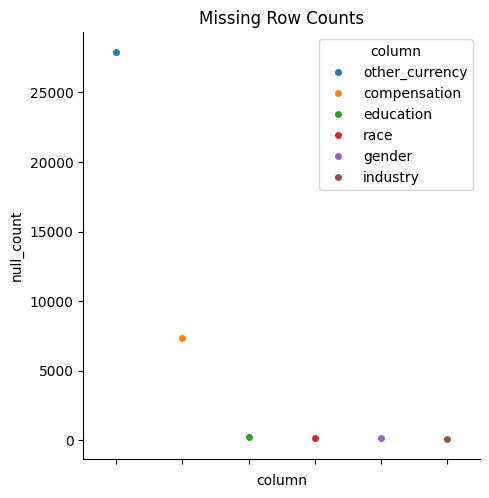

In [160]:
# Plot
p = sns.catplot(
    missing_data,
    x="column",
    y="null_count",
    hue="column",
    legend=True,
    legend_out=False,
)
p.set_xticklabels([])
plt.title("Missing Row Counts")
plt.show()  # pyright: ignore[reportUnknownMemberType]

# Currency Distribution
The majority of the survey results are from US citizens, and are denoted in USD, as shown below:

In [161]:
print("\nCurrency distribution:")
display(df["currency"].value_counts().sort("count", descending=True))

print("\nOther currency distribution:")
display(df["other_currency"].value_counts().sort("count", descending=True))


Currency distribution:


currency,count
str,u32
"""USD""",23444
"""CAD""",1675
"""GBP""",1593
"""EUR""",651
"""AUD/NZD""",505
…,…
"""SEK""",37
"""CHF""",37
"""JPY""",23



Other currency distribution:


other_currency,count
str,u32
null,27928
"""INR""",11
"""SGD""",11
"""USD""",11
"""NOK""",10
…,…
"""American Dollars""",1
"""Option to get 2x or 1.5x if ta…",1
"""RM""",1


# Data Cleaning
Therefore, this EDA will focus on USA citizens salaries, denominated in USD.
We begin by filtering the dataset to workers paid in USD.

In [162]:
df_usd = df.filter(pl.col("currency") == "USD")

# How many rows did we lose?
print(
    f"Rows after filtering to USD: {df_usd.shape[0]} (lost {df.shape[0] - df_usd.shape[0]} rows)"
)

Rows after filtering to USD: 23444 (lost 4709 rows)


We also need to convert the salary from a string to a numerical representation.

In [163]:
df_usd = df_usd.with_columns(
    pl.col("salary")
    .str.replace_all(",", "")
    .cast(pl.Float64, strict=False)
    .alias("numeric_salary_attempt")
)

print("Converted Details:")
display(df_usd["numeric_salary_attempt"].describe())
print("\nNull counts after salary conversion attempt:")
print(df_usd["numeric_salary_attempt"].null_count())

Converted Details:


statistic,value
str,f64
"""count""",23444.0
"""null_count""",0.0
"""mean""",99263.125618
"""std""",754785.809829
"""min""",0.0
"""25%""",56000.0
"""50%""",78000.0
"""75%""",112000.0
"""max""",1.02e8



Null counts after salary conversion attempt:
0


Surprisingly, the data is all valid and no null results are generated. However, the maximum annual salary shown is 102 million, which is... a bit questionable.
Let's investigate further by checking our current dataframe's imbalance.

In [164]:
# Check skewness
print("USD Salary Skewness and Kurtosis")
print(f"Skewness: {df_usd['numeric_salary_attempt'].skew()}")
print(f"Kurtosis: {df_usd['numeric_salary_attempt'].kurtosis()}")

display(df_usd.describe())

USD Salary Skewness and Kurtosis
Skewness: 119.12634694763511
Kurtosis: 15138.534505546662


statistic,age,industry,salary,compensation,currency,other_currency,country,gender,race,job,timestamp,experience_overall_years,experience_field_years,education,numeric_salary_attempt
str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,f64
"""count""","""23444""","""23383""","""23444""",17557.0,"""23444""","""41""","""23444""","""23298""","""23290""","""23444""","""23444""","""23444""","""23444""","""23284""",23444.0
"""null_count""","""0""","""61""","""0""",5887.0,"""0""","""23403""","""0""","""146""","""154""","""0""","""0""","""0""","""0""","""160""",0.0
"""mean""",null,null,null,12723.536481,null,null,null,null,null,null,null,null,null,null,99263.125618
"""std""",null,null,null,46720.665986,null,null,null,null,null,null,null,null,null,null,754785.809829
"""min""","""18-24""",""" Buyer""","""0""",0.0,"""USD""","""$76,302.34""",""" U.S.""","""Man""","""Another option not listed here…",""" Analyst""","""1/11/2022 13:26:41""","""1 year or less""","""1 year or less""","""College degree""",0.0
"""25%""",null,null,null,0.0,null,null,null,null,null,null,null,null,null,null,56000.0
"""50%""",null,null,null,2000.0,null,null,null,null,null,null,null,null,null,null,78000.0
"""75%""",null,null,null,10000.0,null,null,null,null,null,null,null,null,null,null,112000.0
"""max""","""under 18""","""wholesale distribution""","""99952""",1.5e6,"""USD""","""up to 12% annual bonus""","""🇺🇸 ""","""Woman""","""White, Another option not list…","""yard control""","""9/9/2024 18:43:02""","""8 - 10 years""","""8 - 10 years""","""Some college""",1.02e8


Yikes, the skewness and kurtosis are both absurdly high...

Seems like there must be some rather bad outliers. Let's filter out outliers by removing anything with standard deviation > 1

In [165]:
z_scores = np.abs(stats.zscore(df_usd["numeric_salary_attempt"].to_numpy()))
df_clean = df_usd.filter(pl.Series(z_scores <= 1))

print("Filtered Dataframe Details:")
display(df_clean.describe())

print(
    f"Rows after cleaning salary data: {df_clean.shape[0]} (Lost {df_usd.shape[0] - df_clean.shape[0]} rows)"
)
print(f"Skewness: {df_clean['numeric_salary_attempt'].skew():.2f}")
print(f"Kurtosis: {df_clean['numeric_salary_attempt'].kurtosis():.2f}")

Filtered Dataframe Details:


statistic,age,industry,salary,compensation,currency,other_currency,country,gender,race,job,timestamp,experience_overall_years,experience_field_years,education,numeric_salary_attempt
str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,f64
"""count""","""23418""","""23358""","""23418""",17540.0,"""23418""","""38""","""23418""","""23273""","""23265""","""23418""","""23418""","""23418""","""23418""","""23259""",23418.0
"""null_count""","""0""","""60""","""0""",5878.0,"""0""","""23380""","""0""","""145""","""153""","""0""","""0""","""0""","""0""","""159""",0.0
"""mean""",null,null,null,12703.374059,null,null,null,null,null,null,null,null,null,null,90689.484713
"""std""",null,null,null,46668.706299,null,null,null,null,null,null,null,null,null,null,53594.731251
"""min""","""18-24""",""" Buyer""","""0""",0.0,"""USD""","""$76,302.34""",""" U.S.""","""Man""","""Another option not listed here…",""" Analyst""","""1/11/2022 13:26:41""","""1 year or less""","""1 year or less""","""College degree""",0.0
"""25%""",null,null,null,0.0,null,null,null,null,null,null,null,null,null,null,56000.0
"""50%""",null,null,null,2000.0,null,null,null,null,null,null,null,null,null,null,78000.0
"""75%""",null,null,null,10000.0,null,null,null,null,null,null,null,null,null,null,112000.0
"""max""","""under 18""","""wholesale distribution""","""99952""",1.5e6,"""USD""","""up to 12% annual bonus""","""🇺🇸 ""","""Woman""","""White, Another option not list…","""yard control""","""9/9/2024 18:43:02""","""8 - 10 years""","""8 - 10 years""","""Some college""",850000.0


Rows after cleaning salary data: 23418 (Lost 26 rows)
Skewness: 3.05
Kurtosis: 22.40


The skewness and Kurtosis are both much more reasonable!
- The target variable, annual salary, has a very strong positive skewness (3.05), indicating a value imbalance with a long tail of high earners.
- Meanwhile, the kurtosis (22.40) suggests the presence of plenty of outliers, which is common in salary data.

Since the kurtosis is still so high though, let's try a different approach limiting the top earnings to <500,000 USD, and see if that helps.

In [166]:
df_clean = df_usd.filter(pl.col("numeric_salary_attempt") < 500_000)

print("Filtered Dataframe Details:")
display(df_clean.describe())

print(
    f"Rows after cleaning salary data: {df_clean.shape[0]} (Lost {df_usd.shape[0] - df_clean.shape[0]} rows)"
)
print(f"Skewness: {df_clean['numeric_salary_attempt'].skew():.2f}")
print(f"Kurtosis: {df_clean['numeric_salary_attempt'].kurtosis():.2f}")

Filtered Dataframe Details:


statistic,age,industry,salary,compensation,currency,other_currency,country,gender,race,job,timestamp,experience_overall_years,experience_field_years,education,numeric_salary_attempt
str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,f64
"""count""","""23384""","""23324""","""23384""",17519.0,"""23384""","""37""","""23384""","""23239""","""23231""","""23384""","""23384""","""23384""","""23384""","""23227""",23384.0
"""null_count""","""0""","""60""","""0""",5865.0,"""0""","""23347""","""0""","""145""","""153""","""0""","""0""","""0""","""0""","""157""",0.0
"""mean""",null,null,null,12710.610252,null,null,null,null,null,null,null,null,null,null,89906.542807
"""std""",null,null,null,46689.681823,null,null,null,null,null,null,null,null,null,null,49362.55629
"""min""","""18-24""",""" Buyer""","""0""",0.0,"""USD""","""$76,302.34""",""" U.S.""","""Man""","""Another option not listed here…",""" Analyst""","""1/11/2022 13:26:41""","""1 year or less""","""1 year or less""","""College degree""",0.0
"""25%""",null,null,null,0.0,null,null,null,null,null,null,null,null,null,null,56000.0
"""50%""",null,null,null,2000.0,null,null,null,null,null,null,null,null,null,null,78000.0
"""75%""",null,null,null,10000.0,null,null,null,null,null,null,null,null,null,null,111000.0
"""max""","""under 18""","""wholesale distribution""","""99952""",1.5e6,"""USD""","""up to 12% annual bonus""","""🇺🇸 ""","""Woman""","""White, Another option not list…","""yard control""","""9/9/2024 18:43:02""","""8 - 10 years""","""8 - 10 years""","""Some college""",499945.0


Rows after cleaning salary data: 23384 (Lost 60 rows)
Skewness: 1.82
Kurtosis: 6.17


That's much more reasonable, with a skewness of 1.82 and kurtosis of 6.17.

# Annual Salary Visualisation
Now that we have a cleaner dataframe, let's visualise the salary distribution a bit.

Salary Tiers by Percentile:
   10.0th percentile: $   42,000.00
   25.0th percentile: $   56,000.00
   50.0th percentile: $   78,000.00
   75.0th percentile: $  111,000.00
   90.0th percentile: $  152,630.00
   95.0th percentile: $  180,200.00
   99.0th percentile: $  255,000.00


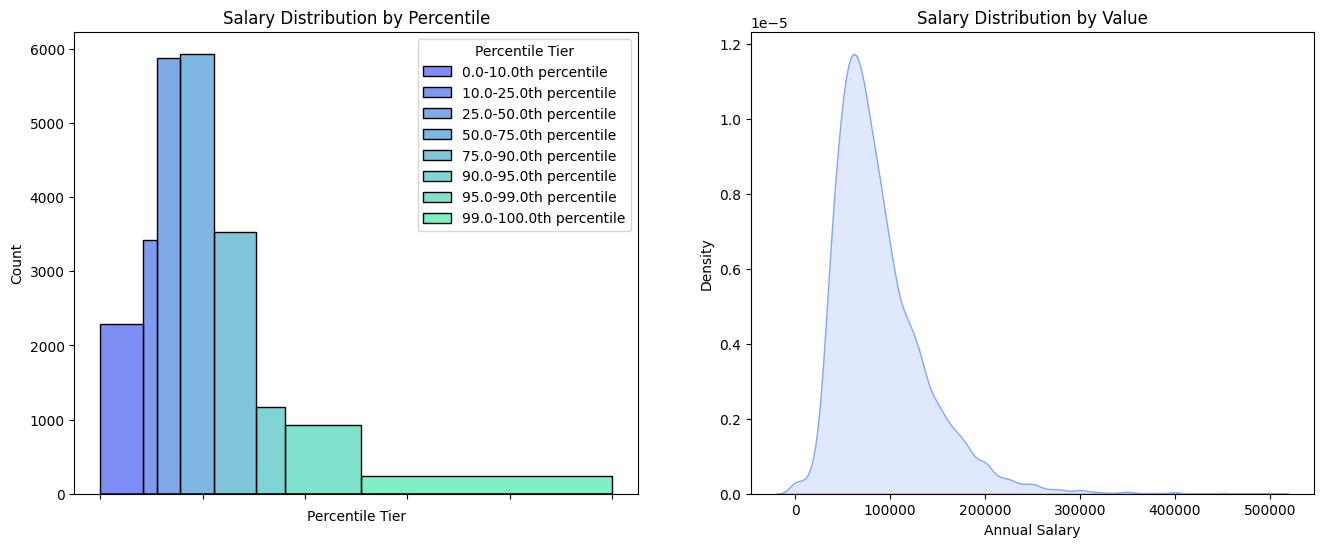

In [167]:
print("Salary Tiers by Percentile:")
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
values = [df_clean["numeric_salary_attempt"].quantile(q) for q in quantiles]
for q, v in zip(quantiles, values):
    print(f"  {q * 100:>5.1f}th percentile: ${v:>12,.2f}")

salary_col = pl.col("numeric_salary_attempt")
expr = (
    pl.when((salary_col >= 0) & (salary_col < values[0]))
    .then(pl.lit(f"0.0-{quantiles[0] * 100:.1f}th percentile"))
    .when((salary_col >= values[0]) & (salary_col < values[1]))
    .then(pl.lit(f"{quantiles[0] * 100:.1f}-{quantiles[1] * 100:.1f}th percentile"))
    .when((salary_col >= values[1]) & (salary_col < values[2]))
    .then(pl.lit(f"{quantiles[1] * 100:.1f}-{quantiles[2] * 100:.1f}th percentile"))
    .when((salary_col >= values[2]) & (salary_col < values[3]))
    .then(pl.lit(f"{quantiles[2] * 100:.1f}-{quantiles[3] * 100:.1f}th percentile"))
    .when((salary_col >= values[3]) & (salary_col < values[4]))
    .then(pl.lit(f"{quantiles[3] * 100:.1f}-{quantiles[4] * 100:.1f}th percentile"))
    .when((salary_col >= values[4]) & (salary_col < values[5]))
    .then(pl.lit(f"{quantiles[4] * 100:.1f}-{quantiles[5] * 100:.1f}th percentile"))
    .when((salary_col >= values[5]) & (salary_col < values[6]))
    .then(pl.lit(f"{quantiles[5] * 100:.1f}-{quantiles[6] * 100:.1f}th percentile"))
    .when((salary_col >= values[6]))
    .then(pl.lit(f"{quantiles[6] * 100:.1f}-100.0th percentile"))
    .otherwise(pl.lit("Out of range"))
    .alias("Percentile Tier")
)

data = df_clean.with_columns([expr]).sort(pl.col("Percentile Tier"))

bwr = sns.color_palette("bwr", 8)
coolwarm = sns.color_palette("coolwarm", 8)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # pyright: ignore[reportUnknownMemberType]

bin_edges = [0] + values + [df_clean["numeric_salary_attempt"].max()]
sns.histplot(
    data,
    x="numeric_salary_attempt",
    hue="Percentile Tier",
    palette="winter",
    bins=bin_edges,
    ax=axes[0],
)
axes[0].set_xticklabels([])
axes[0].set_xlabel("Percentile Tier")

axes[0].set_title(f"Salary Distribution by Percentile")

sns.kdeplot(data, x="numeric_salary_attempt", ax=axes[1], color=coolwarm[1], fill=True)

axes[1].set_xlabel("Annual Salary")
axes[1].set_title("Salary Distribution by Value")

plt.savefig("../../figures/salary_distribution.png", dpi=300)  # pyright: ignore[reportUnknownMemberType]

While we're at it, let's also see if we can alleviate the imbalance by logarizing the annual salary.

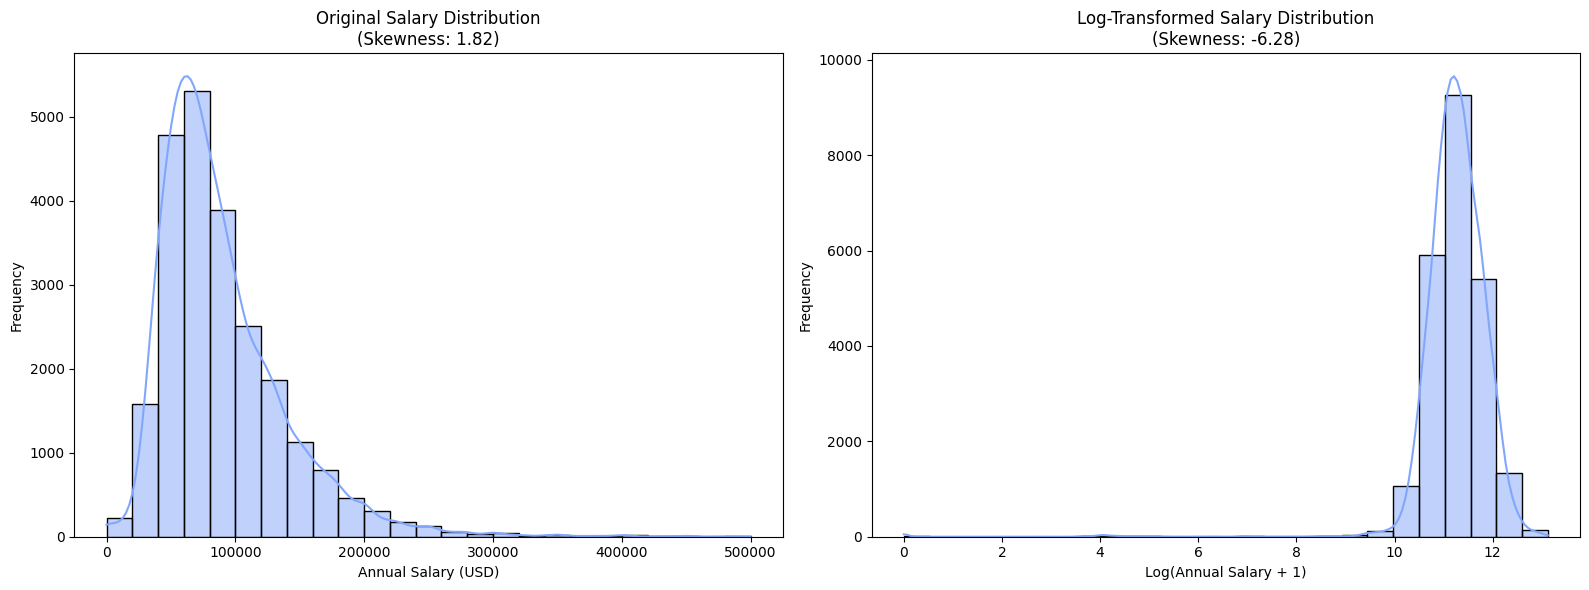

In [169]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # pyright: ignore[reportUnknownMemberType]

sns.histplot(
    df_clean,
    x="numeric_salary_attempt",
    ax=axes[0],
    bins=25,
    kde=True,
    color=coolwarm[1],
)
axes[0].set_title(
    f"Original Salary Distribution\n(Skewness: {df_clean['numeric_salary_attempt'].skew():.2f})"
)
axes[0].set_xlabel("Annual Salary (USD)")
axes[0].set_ylabel("Frequency")

sns.histplot(
    np.log1p(df_clean["numeric_salary_attempt"]),
    bins=25,
    kde=True,
    color=coolwarm[1],
    ax=axes[1],  # pyright: ignore[reportUnknownMemberType]
)
axes[1].set_title(
    f"Log-Transformed Salary Distribution\n(Skewness: {np.log1p(df_clean['numeric_salary_attempt']).skew():.2f})"
)
axes[1].set_xlabel("Log(Annual Salary + 1)")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.savefig("../../figures/salary_distribution_comparison.png", dpi=300)  # pyright: ignore[reportUnknownMemberType]
plt.show()  # pyright: ignore[reportUnknownMemberType]

# Skewness actually incresed from 1.82 to -6.28

# Input Features
Now, let's review our input features, as shown below:

In [170]:
print(df_clean.columns)

['age', 'industry', 'salary', 'compensation', 'currency', 'other_currency', 'country', 'gender', 'race', 'job', 'timestamp', 'experience_overall_years', 'experience_field_years', 'education', 'numeric_salary_attempt']


These features seem to be mostly categorical in nature, with a few numerical features groupe into ordinal categories (e.g. age and experience).

Let's review each feature in comparison to the output target one by one.
## Age

In [171]:
print("Valid Age Responses:")
display(df_clean.select("age").unique().sort("age"))
age_order = ["under 18", "18-24", "25-34", "35-44", "45-54", "55-64", "65 or over"]

Valid Age Responses:


age
str
"""18-24"""
"""25-34"""
"""35-44"""
"""45-54"""
"""55-64"""
"""65 or over"""
"""under 18"""


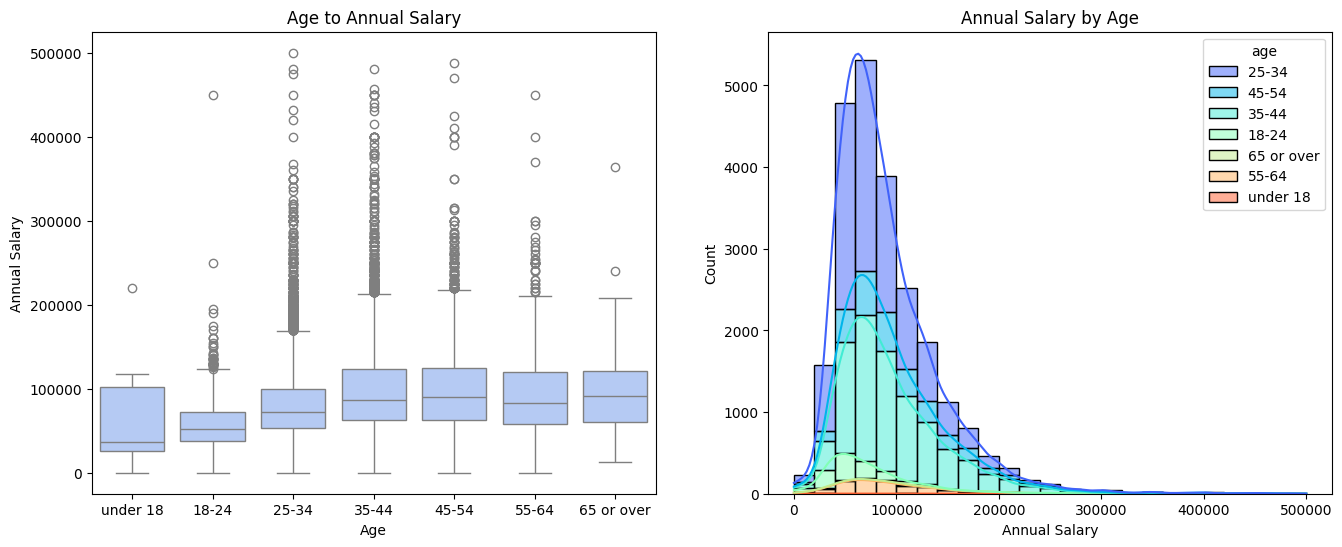

In [172]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # pyright: ignore[reportUnknownMemberType]

sns.boxplot(
    data=df_clean,
    x="age",
    y="numeric_salary_attempt",
    order=age_order,
    ax=axes[0],
    color=coolwarm[2],
)

axes[0].set_title("Age to Annual Salary")
axes[0].set_ylabel("Annual Salary")
axes[0].set_xlabel("Age")

sns.histplot(
    data=df_clean,
    x="numeric_salary_attempt",
    hue="age",
    ax=axes[1],
    palette="rainbow",
    bins=25,
    multiple="stack",
    kde=True,
)

axes[1].set_title("Annual Salary by Age")
axes[1].set_xlabel("Annual Salary")

plt.savefig("../../figures/age_salary.png", dpi=300)  # pyright: ignore[reportUnknownMemberType]

As seen from the graphs above, the median salary generally increases with age until the 35-44 age range. 

The 3rd Interquatile range also follows the same trend, before stabilising at the 35-44 age range.

## Industry

In [173]:
print("Valid Industry Responses")
data = df_clean.filter(pl.col("industry").is_not_null())
display(data.select("industry").unique().sort("industry"))

Valid Industry Responses


industry
str
""" Buyer"""
""" Veterinary medicine"""
"""""Government Relations"" (Lobbyi…"
"""ABA"""
"""Academia """
…
"""technology/SaaS"""
"""trade association"""
"""trade association/membership"""


There are over 1,000 unique industries...
Let's only look at the top n industries first.

In [174]:
n: int = 10
data = data["industry"].value_counts().sort("count", descending=True).head(n)
display(data)

industry,count
str,u32
"""Computing or Tech""",3771
"""Nonprofits""",2138
"""Education (Higher Education)""",2104
"""Health care""",1635
"""Accounting, Banking & Finance""",1493
"""Engineering or Manufacturing""",1446
"""Government and Public Administ…",1427
"""Law""",964
"""Marketing, Advertising & PR""",934


Even after sorting for the most common industries, the results all have a count of a mere 1.

This indicates that this column will be hard to work without Natural Language Processing (NLP) approaches.

# Country

In [175]:
data = df_clean.filter(
    (pl.col("country").is_not_null())
    & (pl.col("country") != "")
    & (pl.col("country").str.len_chars() <= 30)
)

print("Valid Country Responses:")
unique_country_rows = data.select(pl.col("country")).sort("country").unique()
display(unique_country_rows)

Valid Country Responses:


country
str
""" U.S."""
""" US"""
""" United States"""
"""Africa"""
"""America"""
…
"""united states of america"""
"""us"""
"""usa"""


Looking at the shape from the result above, there are 220 unique country responses....

But, there seems to be a lot of duplicates, e.g. "us", "usa", and "usa ".

For this ETA, let's just pick a few with the most occurances.

In [176]:
data = df_clean.filter(
    (pl.col("country").is_not_null())
    & (pl.col("country") != "")
    & (pl.col("country").str.len_chars() <= 30)
)

data = (
    data.with_columns(
        pl.col("country")
        .str.strip_chars()
        .str.to_lowercase()
        .str.replace_all(r"\.", "")
    )
    .with_columns(
        pl.when(
            pl.col("country").str.contains("united state")
            | (pl.col("country").str.contains("usa"))
        )
        .then(pl.lit("usa"))
        .otherwise(pl.col("country"))
        .alias("country")
    )
    .with_columns(
        pl.when(pl.col("country").str.contains("japan"))
        .then(pl.lit("japan"))
        .otherwise(pl.col("country"))
        .alias("country")
    )
)

# Done at last, let's see the unique countries now
data["country"].value_counts().sort("count", descending=True)

country,count
str,u32
"""usa""",19663
"""us""",3395
"""america""",23
"""canada""",19
"""unites states""",17
…,…
"""uganda""",1
"""united y""",1
"""united states""",1


From the result above, we can see that virtually all responses left in our dataframe come from the US.

This is expected, as most of the responses also denominated their annual salary in USD.

# Gender

gender
str
"""Prefer not to answer"""
"""Non-binary"""
"""Woman"""
null
"""Other or prefer not to answer"""
"""Man"""


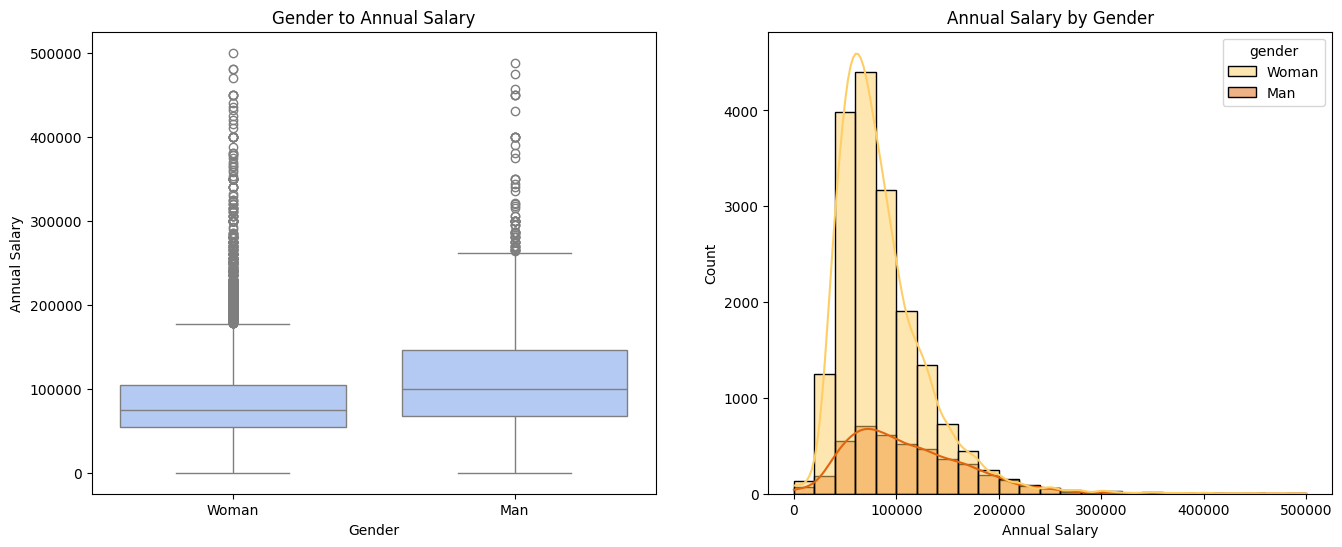

In [177]:
display(df_clean.select("gender").unique())
data = df_clean.filter(pl.col("gender").is_in(["Man", "Woman"]))

fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # pyright: ignore[reportUnknownMemberType]

sns.boxplot(
    data=data,
    x="gender",
    y="numeric_salary_attempt",
    ax=axes[0],
    color=coolwarm[2],
)
axes[0].set_title("Gender to Annual Salary")
axes[0].set_ylabel("Annual Salary")
axes[0].set_xlabel("Gender")

sns.histplot(
    data,
    x="numeric_salary_attempt",
    hue="gender",
    palette="YlOrBr",
    ax=axes[1],
    bins=25,
    kde=True,
)
axes[1].set_title("Annual Salary by Gender")
axes[1].set_xlabel("Annual Salary")

plt.savefig("../../figures/gender_salary.png", dpi=300)  # pyright: ignore[reportUnknownMemberType]

Filtering for only man and woman responses, we get the results above.

Conforming to expectations, men have a higher median annual salary than woman. Men also have a higher 3rd interquatile range, but the 1st interquatile range seems to be about the same.

However, the histogram provides a more nuanced outlook; There are significantly more female responses than male responses, which might skew the data significantly.

Valid Education Responses:


education
str
"""College degree"""
"""Professional degree (MD, JD, e…"
"""Master's degree"""
"""High School"""
null
"""PhD"""
"""Some college"""


/var/folders/9x/42ryqw3d4t70f298p11c89gh0000gn/T/ipykernel_64383/1930352580.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels([textwrap.fill(label.get_text(), 10) for label in axes[0].get_xticklabels()])


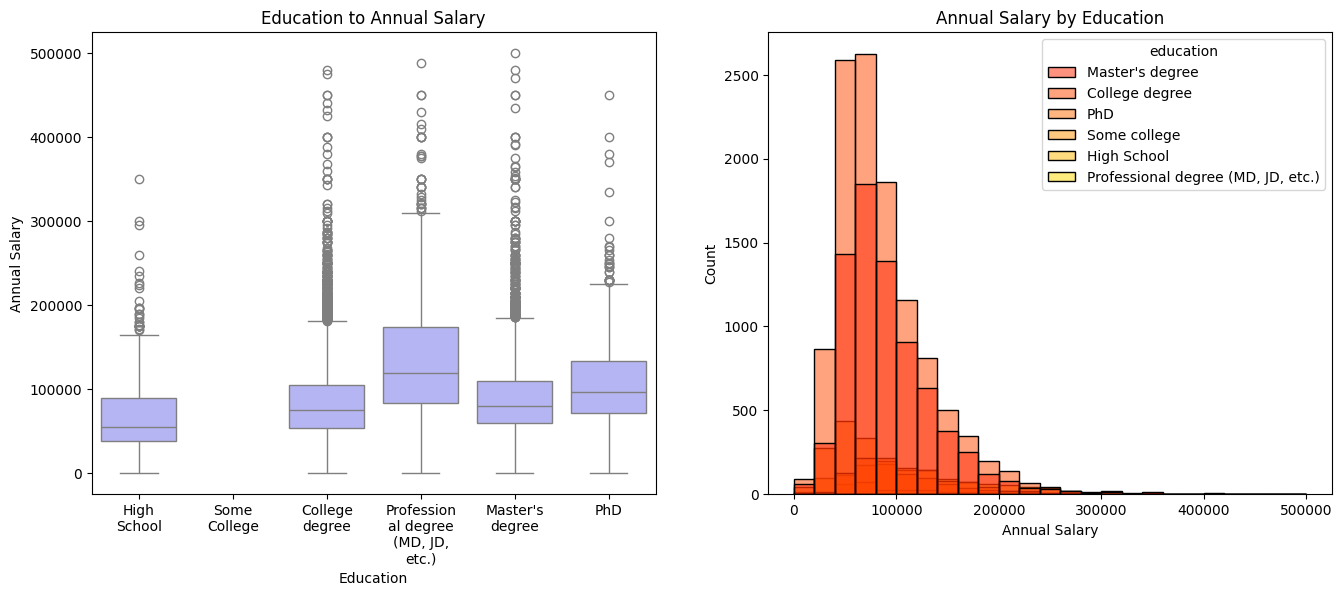

In [178]:
print("Valid Education Responses:")
display(df_clean.select("education").unique())

education_order = [
    "High School",
    "Some College",
    "College degree",
    "Professional degree (MD, JD, etc.)",
    "Master's degree",
    "PhD",
]

data = df_clean.filter(pl.col("education").is_not_null())

fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # pyright: ignore[reportUnknownMemberType]

sns.boxplot(
    data=data,
    x="education",
    y="numeric_salary_attempt",
    order=education_order,
    color=bwr[2],
    ax=axes[0],
)
axes[0].set_title("Education to Annual Salary")
axes[0].set_xlabel("Education")
axes[0].set_ylabel("Annual Salary")

axes[0].set_xticklabels(
    [textwrap.fill(label.get_text(), 10) for label in axes[0].get_xticklabels()]
)


sns.histplot(
    data=data,
    x="numeric_salary_attempt",
    hue="education",
    palette="autumn",
    ax=axes[1],
    bins=25,
)
axes[1].set_title("Annual Salary by Education")
axes[1].set_xlabel("Annual Salary")

plt.savefig("../../figures/education_salary.png", dpi=300)  # pyright: ignore[reportUnknownMemberType]

From the graphs above, we can see that the median annual salary generally grows with education, peaking at Professional degrees (MD, JD, etc.). Then, it lowers for Master and PhD holders.

However, the histogram once again reveals an imbalance in scale; There are more College degree responses than Master's degree responses by a significant margin. This could potentially skew the results, explaining the apparent decline in annual salary with further education.

# Experience

/var/folders/9x/42ryqw3d4t70f298p11c89gh0000gn/T/ipykernel_64383/3625468692.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels([textwrap.fill(label.get_text(), 10) for label in axes[0].get_xticklabels()])


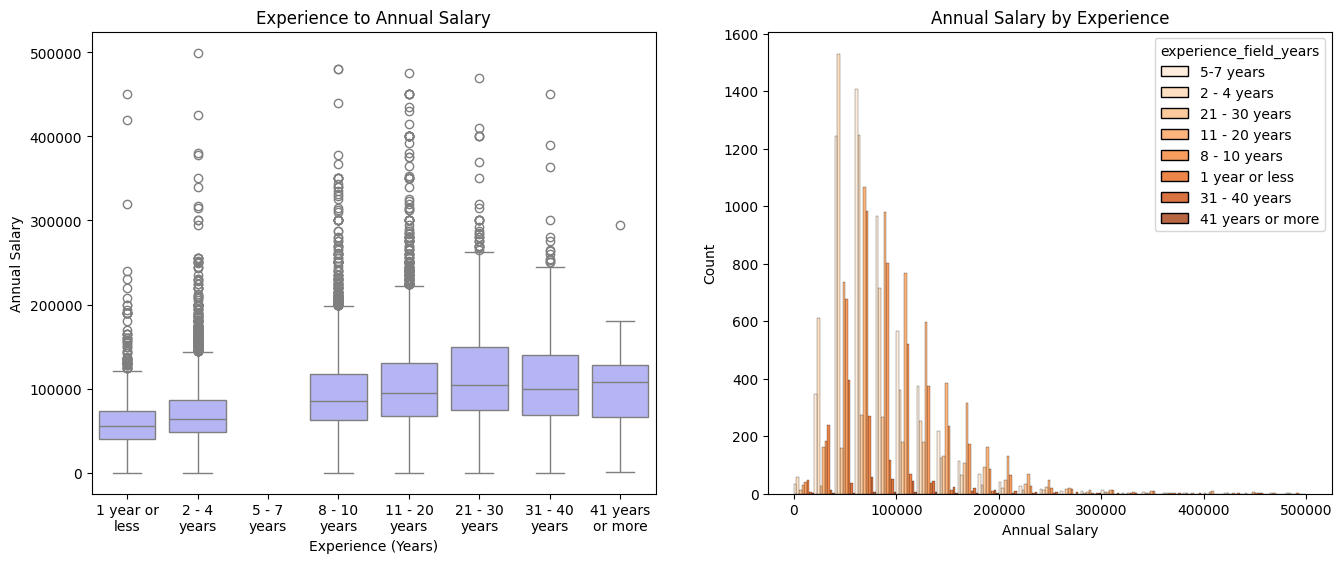

In [179]:
df_clean.select(pl.col("experience_field_years")).unique()

order = [
    "1 year or less",
    "2 - 4 years",
    "5 - 7 years",
    "8 - 10 years",
    "11 - 20 years",
    "21 - 30 years",
    "31 - 40 years",
    "41 years or more",
]

data = df_clean.filter(pl.col("experience_field_years").is_not_null())

fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # pyright: ignore[reportUnknownMemberType]

sns.boxplot(
    data=data,
    x="experience_field_years",
    y="numeric_salary_attempt",
    ax=axes[0],
    order=order,
    color=bwr[2],
)
axes[0].set_title("Experience to Annual Salary")
axes[0].set_xlabel("Experience (Years)")
axes[0].set_ylabel("Annual Salary")

axes[0].set_xticklabels(
    [textwrap.fill(label.get_text(), 10) for label in axes[0].get_xticklabels()]
)

sns.histplot(
    data=data,
    x="numeric_salary_attempt",
    hue="experience_field_years",
    palette="Oranges",
    ax=axes[1],
    bins=25,
    multiple="dodge",
)
axes[1].set_title("Annual Salary by Experience")
axes[1].set_xlabel("Annual Salary")


plt.savefig("../../figures/experience_salary.png", dpi=300)  # pyright: ignore[reportUnknownMemberType]

From the graphs above, we can see that the median annual income does generally grow with age, and the 3rd interquatile range likewise till the age of 30.

The histogram further supports this observation, as the balance of colours turn darker as the annual salary increases.

# Job Titles

Total unique job titles: 12142

Top 10 most frequent Job Titles:


job,count
str,u32
"""Software Engineer""",234
"""Project Manager""",184
"""Director""",172
"""Senior Software Engineer""",167
"""Program Manager""",138
"""Librarian""",133
"""Teacher""",129
"""Manager""",113
"""Executive Assistant""",110


['Software Engineer', 'Project Manager', 'Director', 'Senior Software Engineer', 'Program Manager', 'Librarian', 'Teacher', 'Manager', 'Executive Assistant', 'Product Manager']


/var/folders/9x/42ryqw3d4t70f298p11c89gh0000gn/T/ipykernel_64383/2132102027.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels([textwrap.fill(label.get_text(), 5) for label in axes[0].get_xticklabels()])


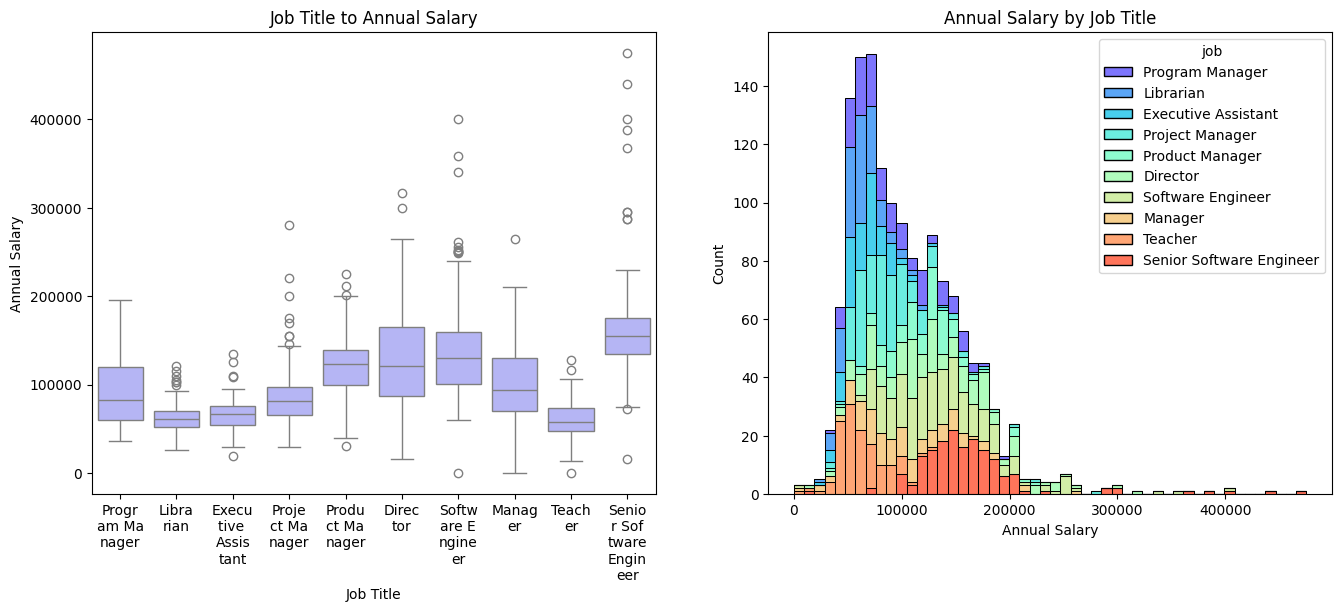

In [180]:
print(f"Total unique job titles: {df_clean['job'].n_unique()}")
print("\nTop 10 most frequent Job Titles:")
display(df_clean["job"].value_counts().sort("count", descending=True).head(10))
jobs = (
    df_clean["job"]
    .value_counts()
    .sort("count", descending=True)
    .head(10)
    .to_dict()["job"]
    .to_list()
)
print(jobs)

data = df_clean.filter(pl.col("job").is_in(jobs))

fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # pyright: ignore[reportUnknownMemberType]

sns.boxplot(
    data=data,
    x="job",
    y="numeric_salary_attempt",
    ax=axes[0],
    color=bwr[2],
)
axes[0].set_title("Job Title to Annual Salary")
axes[0].set_xlabel("Job Title")
axes[0].set_ylabel("Annual Salary")

axes[0].set_xticklabels(
    [textwrap.fill(label.get_text(), 5) for label in axes[0].get_xticklabels()]
)

sns.histplot(
    data=data,
    x="numeric_salary_attempt",
    hue="job",
    palette="rainbow",
    ax=axes[1],
    bins=50,
    multiple="stack",
)
axes[1].set_title("Annual Salary by Job Title")
axes[1].set_xlabel("Annual Salary")


plt.savefig("../../figures/job_salary.png", dpi=300)  # pyright: ignore[reportUnknownMemberType]

Unsurprisingly, job title is highly correlated with annual salary. Jobs like senior software engineer pay better than jobs like teachers or librarians.

However, this data should be taken with a grain of salt as the sample size is tiny, as shown by the histogram above. Although there are over 20,000 rows of data, these graphs don't even make use of a 1,000 of them due to overspecific job titles. Natural Language Processing would be necessary to make use of this column.

# Correlation Matrix
While most features are categorical, several have ordinal relationships (age groups, education levels, experience ranges). 

We can encode these featuresto examine correlations with salary.

numeric_salary_attempt,age_ordinal,education_ordinal,experience_ordinal,experience_overall_ordinal
f64,f64,f64,f64,f64
1.0,0.175528,0.193101,0.30573,0.222062
0.175528,1.0,0.054655,0.63774,0.771231
0.193101,0.054655,1.0,0.025097,-0.022272
0.30573,0.63774,0.025097,1.0,0.756024
0.222062,0.771231,-0.022272,0.756024,1.0


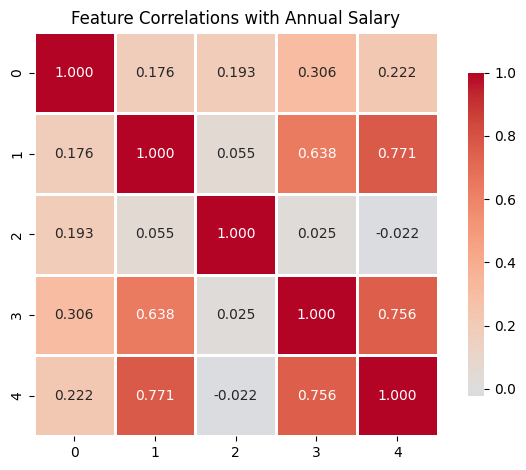

In [181]:
df_corr = df_clean.with_columns(
    [
        # Age as ordinal (0-6)
        pl.col("age")
        .replace(
            {
                "under 18": 0,
                "18-24": 1,
                "25-34": 2,
                "35-44": 3,
                "45-54": 4,
                "55-64": 5,
                "65 or over": 6,
            }
        )
        .cast(pl.Int32)
        .alias("age_ordinal"),
        # Education as ordinal (0-5)
        pl.col("education")
        .replace(
            {
                "High School": 0,
                "Some college": 1,
                "College degree": 2,
                "Master's degree": 3,
                "Professional degree (MD, JD, etc.)": 4,
                "PhD": 5,
            }
        )
        .cast(pl.Int32)
        .alias("education_ordinal"),
        # Experience as ordinal (0-7)
        pl.col("experience_field_years")
        .replace(
            {
                "1 year or less": 0,
                "2 - 4 years": 1,
                "5-7 years": 2,
                "8 - 10 years": 3,
                "11 - 20 years": 4,
                "21 - 30 years": 5,
                "31 - 40 years": 6,
                "41 years or more": 7,
            }
        )
        .cast(pl.Int32)
        .alias("experience_ordinal"),
        # Experience overall as ordinal (same mapping)
        pl.col("experience_overall_years")
        .replace(
            {
                "1 year or less": 0,
                "2 - 4 years": 1,
                "5-7 years": 2,
                "8 - 10 years": 3,
                "11 - 20 years": 4,
                "21 - 30 years": 5,
                "31 - 40 years": 6,
                "41 years or more": 7,
            }
        )
        .cast(pl.Int32)
        .alias("experience_overall_ordinal"),
    ]
)

# Calculate correlation matrix
corr_features = [
    "numeric_salary_attempt",
    "age_ordinal",
    "education_ordinal",
    "experience_ordinal",
    "experience_overall_ordinal",
]

corr_matrix = df_corr.select(corr_features).drop_nulls().corr()
display(corr_matrix)

sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    center=0,
    fmt=".3f",
    square=True,
    linewidths=1,
    cbar_kws={"shrink": 0.8},
)
plt.title("Feature Correlations with Annual Salary")
plt.tight_layout()
plt.savefig("../../figures/correlation_heatmap.png", dpi=300)

# Key Findings
1. Target Variable (Annual Salary)
   - Distribution: Right-Skewed (Skewness = 1.82, Kurtosis = 6.07)
   - This indicates value imbalance with high earners in the tail.
   - Log transformation over-corrects (skewness becomes -6.28)
2. Sample Size
   - Final Dataset: 23,384 (Lost 4,769 Rows due to data filtering and cleaning)
   - Sufficient for Machine Learning and coursework requirements
3. Missing Values
    - Education, Gender, Other Currency has few enough rows with null values to just be filtered out
    - Experience also has some rows with null values
4. High Cardianlity Features
   - Industry (1,046 Unique Values), Job Titles (12,142 Unique Values)
   - Country has many unique values, but the vast majority of responses are from the US 
   - This project will focus on US citizens earning USD since other countries are barely present in the dataset
   - May need more effort to group Industry and Job Titles rows together
5. Correlation Matrix
   - Slight Correlations: Age (17.6%), Education, (19.3%)
   - Moderate Correlations: Field Experience (30.6%), Overall Experience (22.2%)
6. Data Quality
   - Country Names: Many typos
   - Industry/Job: Free-text entries → inconsistent naming
   - Timestamp: Could extract temporal features (month, year)
7. Feature Engineering
   - Could create "experience_ratio" = overall experience / field experience
   - Could create education * experience interaction term
   - Extract years and dates from timestamp if relevant